In [1]:
import fix_project_path

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from evaluate.segmentations import do_property_binning
from config.datasets import datasets
from config.repositories import repositories
from paths import makedirs


%load_ext autoreload
%autoreload 2

In [21]:
data_keys = {
    #'gazebase_all_sr1000_sl1000_dxy': "GazeBase (1000 s)",
    #'gazebase_all_sr1000_sl5000_savgol_maxvel500_dxy': "GazeBase",# (5000 s)",
    #'gazebase_all_sr1000_sl5000_savgol_maxvel750_dxy': "GazeBase",# (5000 s)",
    'gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy': "GazeBase",# (5000 s)",

    #'judo_sr1000_sl1000_rxy': "JuDo1000 (right eye)",
    #'judo_sr1000_sl1000_savgol_maxvel500_bxy': "JuDo1000",# (both eyes)",
    #'judo_sr1000_sl1000_savgol_maxvel750_bxy': "JuDo1000",# (both eyes)",
    'judo_sr1000_sl1000_savgol_maxvel1000_bxy': "JuDo1000",# (both eyes)",

    #'potec_sr1000_sl1000_savgol_maxvel500_dxy': "PoTeC",
    #'potec_sr1000_sl1000_savgol_maxvel750_dxy': "PoTeC",
    'potec_sr1000_sl1000_savgol_maxvel1000_dxy': "PoTeC",
}


model_keys = {
    'eky2': "EKY2",
    #'del_slow': "DELslow",
    #'del_fast_zstd': "DELfast0",
    #'del_zstd': "DEL0",
    #'del_fast_vmin1': "DELfast1",
    #'del_vmin1': "DEL1",
    #'del_fast_vmin4': "DELfast",
    #'del_vmin4': "DEL",
    #'del_fast_vmin10': "DELfast10",
    #'del_vmin10': "DEL",
    #'del_fast': "DELfast40",
    #'del': "DEL40",
}

explainer_keys = {
    'deeplift_zero': 'DL',
    #'input_x_gradient': 'IxG',
    'integrated_gradients_zero': 'IG',
    #'occlusion_s3': 'Occ(3)',
    #'occlusion_s5': 'Occ(5)',

    #'lrp_epsilon0_only': 'LRP-ε0',
    'lrp_epsilon0.25_only': 'LRP',#-Ε',
    #'lrp_epsilon1e-6_only': 'LRP-ε',
    
    #'lrp_epsilon_plus': 'LRP-ε+',
    #'lrp_epsilon_plus_flat': 'LRP-ε+♭',
    
    #'lrp_epsilon_gamma0.25': 'LRP-γ',
    #'lrp_epsilon_gamma0.25_flat': 'LRP-γ♭',
    #'lrp_epsilon_gamma0.1': 'LRP-εγ.1',
    #'lrp_epsilon_gamma0.1_flat': 'LRP-εγ.1♭',

    #'lrp_epsilon_alpha2_beta1': 'LRP-α2β1',
    #'lrp_epsilon_alpha2_beta1_flat': 'LRP-α2β1♭',
    #'lrp_epsilon_alpha1_beta0': 'LRP-α1β0',
    #'lrp_epsilon_alpha1_beta0_flat': 'LRP-α1β0♭',
}

metric_keys = {
    #'area_under_curve': 'score',
    #'attribution_localisation': 'score',
    #'attribution_localisation_weighted': 'score',
    #'localized_attribution_aggregate_max': 'score',
    #'localized_attribution_aggregate_mean': 'score',
    #'localized_attribution_aggregate_median': 'score',
    #'pointing_game': 'score',
    #'pointing_game_weighted': 'score',
    #'relevance_mass_accuracy': 'score',
    #'top_1_percent_intersection': 'score',
    #'top_1_percent_intersection_concept_influence': 'score',
    'top_2_percent_intersection': 'top k intersection',
    'top_2_percent_intersection_concept_influence': 'concept influence',
    #'top_5_percent_intersection': 'score',
    #'top_5_percent_intersection_concept_influence': 'score',
    #'top_10_percent_intersection': 'score',
    #'top_10_percent_intersection_concept_influence': 'score',
    #'top_20_percent_intersection': 'score',
    #'top_20_percent_intersection_concept_influence': 'score',
}

segmentation_keys = {
    #'clip': 'clip',
    #'nan': 'nan',
    'ivt.fixation': 'fixation',
    #'engbert.saccade': 'saccade',
    #'engbert.saccade.monocular': 'saccade.monocular',
}

event_property_keys = [
    'dispersion',
    'duration',
    'v_std',
]

n_bins = 100

basepath = Path('/mnt/scratch/anonymous/workspace/xai-timeseries/')

In [3]:
index = pd.MultiIndex.from_product(
    iterables=[
        data_keys.keys(),
        model_keys.keys(),
        explainer_keys.keys(),
        metric_keys.keys(),
        segmentation_keys.keys(),
        event_property_keys,
        list(range(n_bins)),
    ],
    names=['data', 'model', 'explainer', 'metric', 'segmentation', 'event_property', 'property_bin'],
)

scores = pd.DataFrame(index=index, columns=['score'])

scores.head()

score
data                                             model explainer     metric                     segmentation event_property property_bin      
gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy eky2  deeplift_zero top_2_percent_intersection ivt.fixation dispersion     0              NaN
                                                                                                                            1              NaN
                                                                                                                            2              NaN
                                                                                                                            3              NaN
                                                                                                                            4              NaN

In [4]:
scorepath_pattern = '/mnt/scratch/anonymous/workspace/xai-timeseries/evaluations/attribution_localization/{data_key}/{model_key}/{explainer_key}/{metric_key}/{segmentation_key}_binning_{event_property}_n100/scores.npy'

event_properties = {}
segmentations = {}

for data_key in tqdm(data_keys):
    repo_key = datasets[data_key]['repo_key']
    repo_path = Path(repositories[repo_key]['dirpath'])
    
    event_dirpath = basepath / repo_path / 'events'

    segmentation_filepath = event_dirpath / 'ivt.fixation.npy'
    properties_filepath = event_dirpath / 'ivt.fixation.csv'

    try:
        segmentations[data_key] = np.load(segmentation_filepath)
        event_properties_dataset = pd.read_csv(properties_filepath)
        event_properties_dataset['data'] = data_key
    except:
        continue

    event_properties_dataset['duration'] = event_properties_dataset['offset'] - event_properties_dataset['onset']
    event_properties_dataset['duration'] = event_properties_dataset['duration'].clip(upper=1000)    
    event_properties[data_key] = event_properties_dataset

    #fold_ids = list(fold_indices[data_key].keys())
    for model_key in tqdm(model_keys.keys(), leave=False):
        for explainer_key in tqdm(explainer_keys.keys(), leave=False):
            for metric_key in tqdm(metric_keys.keys(), leave=False):
                for segmentation_key in tqdm(segmentation_keys.keys(), leave=False):
                    for event_property in tqdm(event_property_keys, leave=False):

                        filepath = Path(scorepath_pattern.format(
                            data_key=data_key,
                            model_key=model_key,
                            explainer_key=explainer_key,
                            metric_key=metric_key,
                            segmentation_key=segmentation_key,
                            event_property=event_property,
                        ))

                        if filepath.exists():
                            score = np.load(filepath)

                            result_idx = data_key, model_key, explainer_key, metric_key, segmentation_key, event_property
                            scores.loc[result_idx, 'score'] = np.nanmean(score, axis=0)

                            #for fold_id in fold_ids:
                            #    fold_mask = fold_indices[data_key][fold_id]['test']
                            #    score_fold = score[fold_mask]

                            #    result_idx = data_key, model_key, explainer_key, metric_key, segmentation_key, fold_id
                            #    df.loc[result_idx, 'score'] = np.nanmean(score_fold)

                        else:
                            print(f'skip {filepath}')

display(scores)

  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

  0%|                                                                                                                                                                                        | 0/3 [00:00<?, ?it/s]


  0%|                                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]



  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]




  0%|                                                                                                                                         

  0%|                                                                                                                                                                                        | 0/3 [00:00<?, ?it/s]




 33%|██████████████████████████████████████████████████████████▋                                                                                                                     | 1/3 [00:00<00:00,  6.45it/s]




 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2/3 [00:00<00:00,  6.65it/s]




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.54it/s]




                                                                                                                                        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]



                                                                                                                                                                                                                   


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.39it/s]


                                                                                                                                                                                                                   

 33%|██████████████████████████████████████████████████████████▋                                                                                

score
data                                             model explainer            metric                                       segmentation event_property property_bin          
gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy eky2  deeplift_zero        top_2_percent_intersection                   ivt.fixation dispersion     0                  0.0
                                                                                                                                                     1             0.000377
                                                                                                                                                     2             0.000655
                                                                                                                                                     3             0.000448
                                                                                                                                                     4             0.000702
...                                                                                                                                                                     ...
potec_sr1000_sl1000_savgol_maxvel1000_dxy        eky2  lrp_epsilon0.25_only top_2_percent_intersection_concept_influence ivt.fixation v_std          95                 0.0
                                                                                                                                                     96                 0.0
                                                                                                                                                     97                 0.0
                                                                                                                                                     98                 NaN
                                                                                                                                                     99                 0.0

[5400 rows x 1 columns]

In [5]:
scores = scores.reset_index()

scores.data = scores.data.map(data_keys)
scores.model = scores.model.map(model_keys)
scores.explainer = scores.explainer.map(explainer_keys)
scores.metric = scores.metric.map(metric_keys)

display(scores)

,data,model,explainer,metric,segmentation,event_property,property_bin,score
0,GazeBase,EKY2,DL,Top K Intersection,ivt.fixation,dispersion,0,0.0
1,GazeBase,EKY2,DL,Top K Intersection,ivt.fixation,dispersion,1,0.000377
2,GazeBase,EKY2,DL,Top K Intersection,ivt.fixation,dispersion,2,0.000655
3,GazeBase,EKY2,DL,Top K Intersection,ivt.fixation,dispersion,3,0.000448
4,GazeBase,EKY2,DL,Top K Intersection,ivt.fixation,dispersion,4,0.000702
...,...,...,...,...,...,...,...,...
5395,PoTeC,EKY2,LRP,Concept Influence,ivt.fixation,v_std,95,0.0
5396,PoTeC,EKY2,LRP,Concept Influence,ivt.fixation,v_std,96,0.0
5397,PoTeC,EKY2,LRP,Concept Influence,ivt.fixation,v_std,97,0.0
5398,PoTeC,EKY2,LRP,Concept Influence,ivt.fixation,v_std,98,NaN


In [6]:
event_properties = pd.concat(list(event_properties.values()))
event_properties.data = event_properties.data.map(data_keys)

event_properties = event_properties.reset_index(drop=True)

display(event_properties)

,Unnamed: 0,instance_id,onset,offset,v_std,v_peak,dispersion,data,duration
0,0,0,0,306,5.030635,16.644997,0.283000,GazeBase,306
1,1,0,330,714,5.030996,18.108238,0.465300,GazeBase,384
2,2,0,767,896,5.296270,16.995965,0.339800,GazeBase,129
3,3,0,940,1015,5.526720,18.992006,0.358400,GazeBase,75
4,4,0,1043,1247,4.987724,18.780344,0.523400,GazeBase,204
...,...,...,...,...,...,...,...,...,...
2256421,518592,107538,837,887,5.154326,17.379977,0.217882,PoTeC,50
2256422,518593,107539,232,308,6.568760,18.551570,0.285121,PoTeC,76
2256423,518594,107539,425,488,7.287155,19.580116,0.279153,PoTeC,63
2256424,518595,107539,560,621,6.187700,18.574184,0.190447,PoTeC,61


In [7]:
all_bins = {
    data_key: {
        event_property_key: None for event_property_key in event_property_keys
    }
    for data_key in data_keys.keys()
}

all_binseg = {
    data_key: {
        event_property_key: None for event_property_key in event_property_keys
    }
    for data_key in data_keys.keys()
}

for data_key, data_name in data_keys.items():
    for event_property in event_property_keys:
        dataset_df = event_properties[event_properties.data == data_name]

        print(data_key, event_property)
        bins, binseg = do_property_binning(segmentations[data_key], dataset_df, event_property, n_bins)
        all_bins[data_key][event_property] = bins
        all_binseg[data_key][event_property] = binseg


gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy dispersion


gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy duration


gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy v_std


judo_sr1000_sl1000_savgol_maxvel1000_bxy dispersion


judo_sr1000_sl1000_savgol_maxvel1000_bxy duration


judo_sr1000_sl1000_savgol_maxvel1000_bxy v_std


potec_sr1000_sl1000_savgol_maxvel1000_dxy dispersion


potec_sr1000_sl1000_savgol_maxvel1000_dxy duration


potec_sr1000_sl1000_savgol_maxvel1000_dxy v_std


In [8]:
binseg_means = {
    data_key: {
        event_property_key: None
        for event_property_key in event_property_keys
    }
    for data_key in data_keys.keys()
}

for data_key in tqdm(data_keys.keys()):
    event_property for tqdm(event_properties):
        binseg_means[data_key][event_proeprty] = np.mean(all_binseg[data_key][event_property], axis=(0,2))


'\nbinseg_means = {\n    data_key: {\n        event_property_key: None\n        for event_property_key in event_property_keys\n    }\n    for data_key in data_keys.keys()\n}\n\nfor data_key in tqdm(data_keys.keys()):\n    event_property for tqdm(event_properties):\n        binseg_means[data_key][event_proeprty] = np.mean(all_binseg[data_key][event_property], axis=(0,2))\n'

In [9]:
plot_dirpath = Path('/home/anonymous/workspace/xai-timeseries/plots/event_property_binning/')
makedirs(plot_dirpath)

In [10]:
def plot_all(event_property, xlabel=None, figsize=(15, 3)):
    fig, axs = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
    for plot_id, data_name in enumerate(data_keys.values()):
        dataset_ax = axs[plot_id]
        dataset_df = event_properties[event_properties.data == data_name]

        sns.histplot(dataset_df, x=event_property, bins=n_bins, stat='percent', ax=dataset_ax)
        dataset_ax.set_title(data_name)
        dataset_ax.set_xlabel(xlabel)
        
    plt.tight_layout(pad=0.8)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    savepath = plot_dirpath / f'fixation-{event_property}-counts.pdf'
    plt.savefig(savepath)
    print(savepath)
    plt.show()

    fig, axs = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
    for plot_id, (data_key, data_name) in enumerate(data_keys.items()):
        dataset_ax = axs[plot_id]
        dataset_df = event_properties[event_properties.data == data_name]

        dataset_ax.set_title(data_name)
        dataset_ax.set_xlabel(event_property)
        if plot_id == 0:
            dataset_ax.set_ylabel('avg segmentation ratio')
        dataset_ax.set_xlabel(xlabel)

        dataset_ax.plot(all_bins[data_key][event_property],
                        binseg_means[data_key][event_property] * 100)

    plt.tight_layout(pad=0.8)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    savepath = plot_dirpath / f'fixation-{event_property}-size.pdf'
    plt.savefig(savepath)
    print(savepath)
    plt.show()


    for metric in scores.metric.unique():
        if metric == 'Top K Intersection':
            metric_abbr = 'tki'
        elif metric == 'Concept Influence':
            metric_abbr = 'ci'
        else:
            raise ValueError(metric)

        fig, axs = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
        for plot_id, (data_key, data_name) in enumerate(data_keys.items()):
            dataset_ax = axs[plot_id]
            dataset_df = event_properties[event_properties.data == data_name]

            dataset_ax.set_title(data_name)
            dataset_ax.set_xlabel(event_property)
            if plot_id == 0:
                dataset_ax.set_ylabel(metric)
            dataset_ax.set_xlabel(xlabel)

            for explainer in scores.explainer.unique():
                this_scores = scores[
                    (scores.data == data_name) &
                    (scores.event_property == event_property) &
                    (scores.metric == metric) &
                    (scores.explainer == explainer)
                ].score
                dataset_ax.plot(
                    all_bins[data_key][event_property], this_scores, label=explainer,
                )

        plt.legend()
        
        plt.tight_layout(pad=0.8)
        plt.subplots_adjust(hspace=0.1, wspace=0.1)
        savepath = plot_dirpath / f'fixation-{event_property}-{metric_abbr}.pdf'
        plt.savefig(savepath)
        print(savepath)
        plt.show()

In [25]:
def plot_metrics(event_property, xlabel=None, figsize=(15, 3)):
    plt.rcParams.update({'font.size': 17})
    for metric in scores.metric.unique():
        if metric == 'top k intersection':
            metric_abbr = 'tki'
        elif metric == 'concept influence':
            metric_abbr = 'ci'
        else:
            raise ValueError(metric)

        fig, axs = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
        for plot_id, (data_key, data_name) in enumerate(data_keys.items()):
            dataset_ax = axs[plot_id]
            dataset_df = event_properties[event_properties.data == data_name]

            dataset_ax.set_title(data_name)
            dataset_ax.set_xlabel(event_property)
            if plot_id == 0:
                dataset_ax.set_ylabel(metric)
            dataset_ax.set_xlabel(xlabel)

            for explainer in scores.explainer.unique():
                this_scores = scores[
                    (scores.data == data_name) &
                    (scores.event_property == event_property) &
                    (scores.metric == metric) &
                    (scores.explainer == explainer)
                ].score
                
                #if data_name == 'JuDo1000':
                #    this_scores /= 2
                
                dataset_ax.plot(
                    all_bins[data_key][event_property], this_scores, label=explainer,
                )
                
            dataset_ax.spines['top'].set_visible(False)
            dataset_ax.spines['right'].set_visible(False)
            dataset_ax.axhline(1, color='gray', linestyle='--')


        #plt.legend()
        
        plt.tight_layout(pad=0.8)
        plt.subplots_adjust(hspace=0.1, wspace=0.1)
        savepath = plot_dirpath / f'fixation-{event_property}-{metric_abbr}.pdf'
        plt.savefig(savepath)
        print(savepath)
        plt.show()

event_property = 'duration'
/home/anonymous/workspace/xai-timeseries/plots/event_property_binning/fixation-duration-tki.pdf


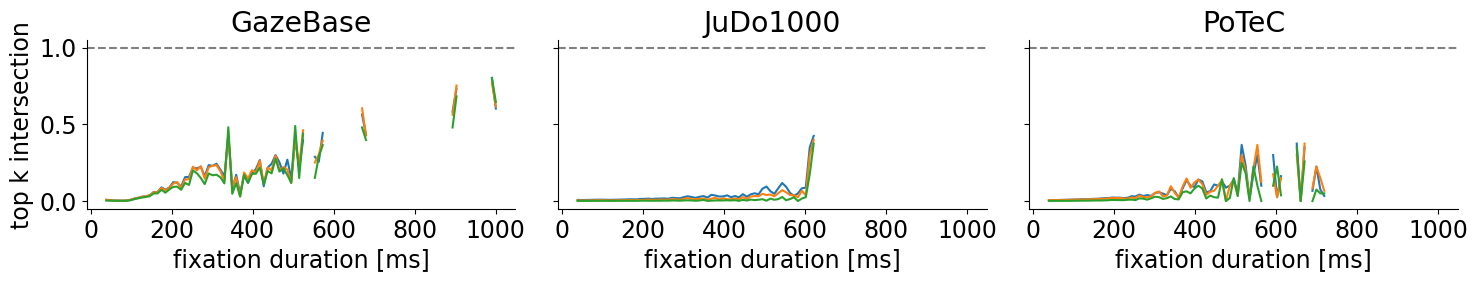

/home/anonymous/workspace/xai-timeseries/plots/event_property_binning/fixation-duration-ci.pdf


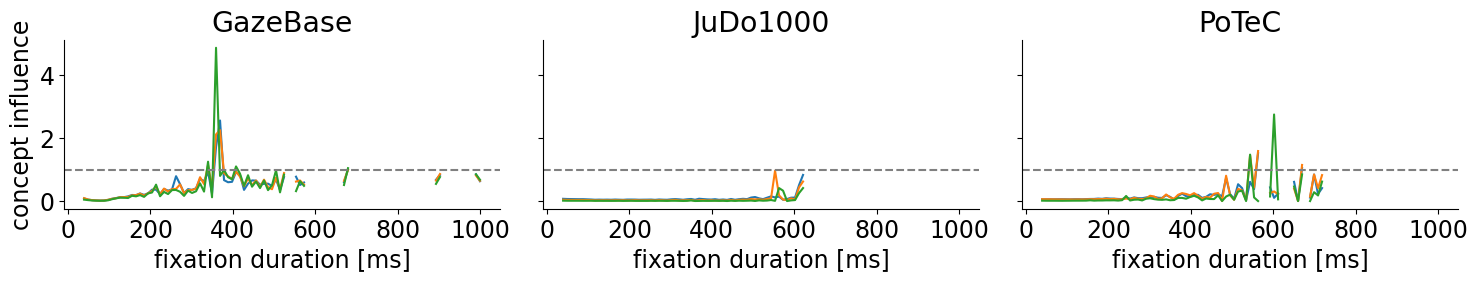

In [26]:
event_property = 'duration'
print(f'{event_property = }')
plot_metrics(event_property, xlabel='fixation duration [ms]')

event_property = 'v_std'
/home/anonymous/workspace/xai-timeseries/plots/event_property_binning/fixation-v_std-tki.pdf


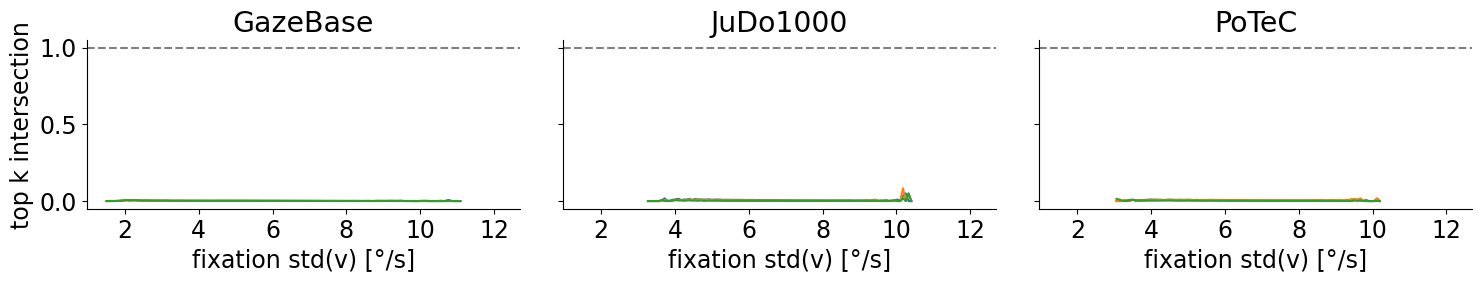

/home/anonymous/workspace/xai-timeseries/plots/event_property_binning/fixation-v_std-ci.pdf


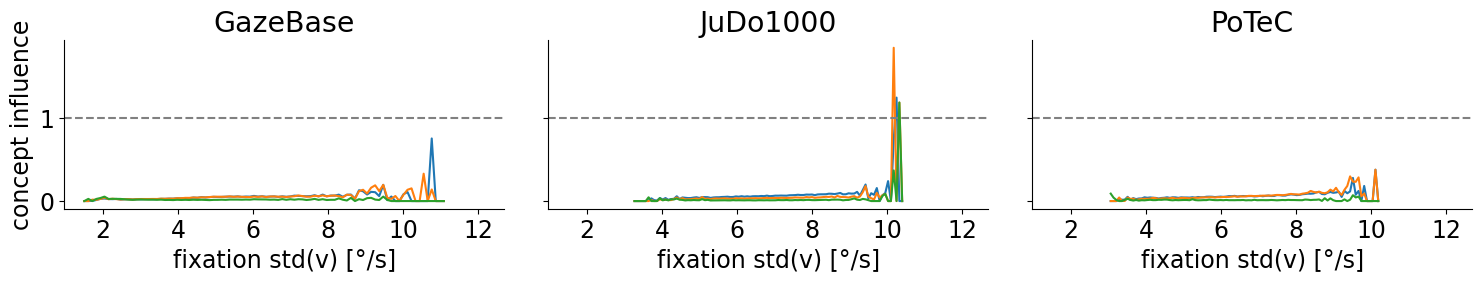

In [27]:
event_property = 'v_std'
print(f'{event_property = }')
plot_metrics(event_property, xlabel='fixation std(v) [°/s]')

event_property = 'dispersion'
/home/anonymous/workspace/xai-timeseries/plots/event_property_binning/fixation-dispersion-tki.pdf


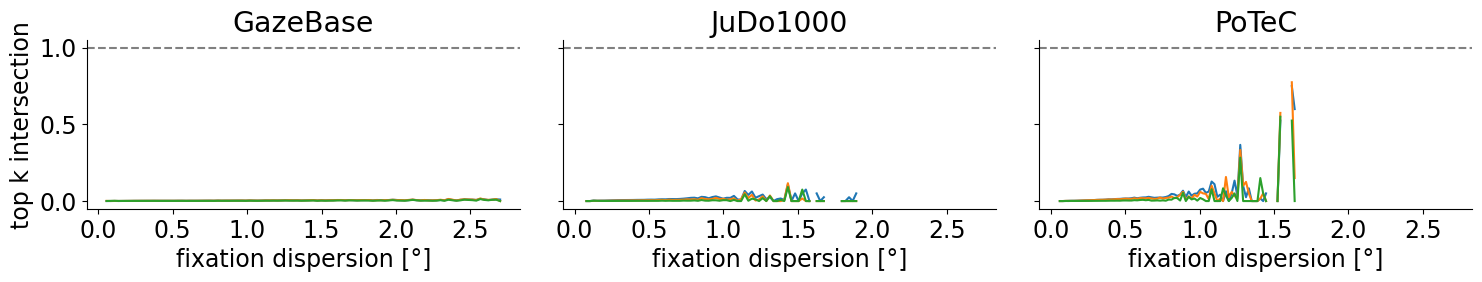

/home/anonymous/workspace/xai-timeseries/plots/event_property_binning/fixation-dispersion-ci.pdf


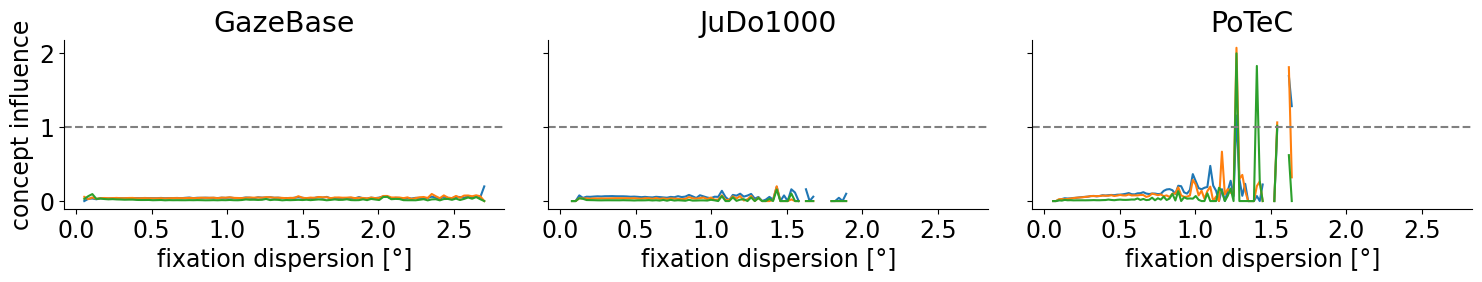

In [28]:
event_property = 'dispersion'
print(f'{event_property = }')
plot_metrics(event_property, xlabel='fixation dispersion [°]')